The purpose of the code is to predict customer response to marketing campaigns/

Question: Predict Customer Response to Marketing Campaigns
* The model predicts whether a customer will respond (1) or not respond (0) to a marketing campaign.
* Business Value: Helps companies target the right customers and improve campaign success rates.


# Step 1: Importing Required Libraries

* pandas, numpy → Data processing
* matplotlib, seaborn → Data visualization
* train_test_split, GridSearchCV → Splitting data & hyperparameter tuning
LogisticRegression, RandomForestClassifier → Machine learning models
* accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report → Model evaluation metrics
* OneHotEncoder, StandardScaler → Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE

# Step 2: Load the dataset and Data Quality Control

In [24]:
file_path = './data/processed/marketing_campaign_transofrmed_with_clusters.csv'
df = pd.read_csv(file_path, sep=',')

df.head(5)

,Total_Spending,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Total_Purchase_Num,NumWebPurchases,NumCatalogPurchases,...,AcceptedCmp4,AcceptedCmp5,Response,Campaign_Response_Rate,Complain,Loyalty_Months,Recency,NumWebVisitsMonth,ID,Cluster
0,1617,635,88,546,172,88,88,22,8,10,...,0,0,1,0.166667,0,152,58,7,5524,0
1,27,11,1,6,2,1,6,4,1,1,...,0,0,0,0.000000,0,134,38,5,2174,3
2,776,426,49,127,111,21,42,20,8,2,...,0,0,0,0.000000,0,140,26,4,4141,4
3,53,11,4,20,10,3,5,6,2,0,...,0,0,0,0.000000,0,135,26,6,6182,2
4,422,173,43,118,46,27,15,14,5,3,...,0,0,0,0.000000,0,135,94,5,5324,3


# Step 3: Define Features (X) and Target (y)
* X → Independent variables (all columns except "Response").
* y → Target variable ("Response") → 1 (Responded), 0 (Not Responded).

In [25]:
# Drop highly correlated features and ID
high_corr_features=['MntWines', 'MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','Kidhome', 'Teenhome','Total_Children','AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','Campaign_Response_Rate','ID']
df= df.drop(columns=high_corr_features)

X = df.drop(columns=['Response'])  # Features excluding target variable
y = df['Response']  # Target variable

print("----- X ---------")
print(X)
print("----- y ---------")
print(y)

----- X ---------
      Total_Spending  Total_Purchase_Num  Discount_Dependency   Income  Age  \
0               1617                  22             0.136364  58138.0   67   
1                 27                   4             0.500000  46344.0   70   
2                776                  20             0.050000  71613.0   59   
3                 53                   6             0.333333  26646.0   40   
4                422                  14             0.357143  58293.0   43   
...              ...                 ...                  ...      ...  ...   
2199            1341                  16             0.125000  61223.0   57   
2200             444                  15             0.466667  64014.0   78   
2201            1241                  18             0.055556  56981.0   43   
2202             843                  21             0.095238  69245.0   68   
2203             172                   8             0.375000  52869.0   70   

      Education  Marital_Merged_C

In [26]:
encoder = OneHotEncoder(sparse_output=False)
encoded_clusters = encoder.fit_transform(X[["Cluster"]])
encoded_clusters_df = pd.DataFrame(encoded_clusters, columns=encoder.get_feature_names_out(["Cluster"]))

# Merge encoded clusters into dataset & drop original cluster column
X = pd.concat([X.drop(columns=["Cluster"]), encoded_clusters_df], axis=1)

# Step 5: Split Data into Training and Testing Sets

* Splits the dataset into 80% training and 20% testing.
* Stratify=y ensures that both training and test sets have the same proportion of class labels.


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.dtypes)
print(X_train.head(5))

Total_Spending                       int64
Total_Purchase_Num                   int64
Discount_Dependency                float64
Income                             float64
Age                                  int64
Education                            int64
Marital_Merged_Couples               int64
Marital_Merged_Single_Household      int64
Total_Household_Size                 int64
Complain                             int64
Loyalty_Months                       int64
Recency                              int64
NumWebVisitsMonth                    int64
Cluster_0                          float64
Cluster_1                          float64
Cluster_2                          float64
Cluster_3                          float64
Cluster_4                          float64
dtype: object
      Total_Spending  Total_Purchase_Num  Discount_Dependency   Income  Age  \
1152            1711                  15             0.066667  74214.0   34   
310               65                   6             0

# Step 6: Create a Standard Scaler

* Creates an instance of StandardScaler, which normalizes numerical features by scaling them to have a mean of 0 and a standard deviation of 1.
* Specifies categorical or binary columns that should not be scaled (e.g., one-hot encoded marital status and complaint response).
* Selects all numeric columns from the training data.
* Filters out the excluded columns to ensure only relevant numerical features are scaled.
* Creates a copy of X_train to store the scaled values.
* Fits and transforms numerical features using StandardScaler.
* Creates a copy of X_test to store the scaled values.
* Uses the same scaling parameters (fitted on X_train) to transform X_test.
* Displays the first 5 rows of the scaled test dataset to verify that the transformation was applied correctly.

In [28]:
scaler = StandardScaler()
columns_to_exclude = ['Marital_Merged_Single_Household','Marital_Merged_Couples', 'Complain','Cluster_0','Cluster_1','Cluster_2','Cluster_3','Cluster_4']

numerical_columns = X_train.select_dtypes(include=['number']).columns
columns_to_scale = [col for col in numerical_columns if col not in columns_to_exclude]

# Scale numerical features
X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.transform(X_test_scaled[columns_to_scale])

X_test_scaled.head(5)


,Total_Spending,Total_Purchase_Num,Discount_Dependency,Income,Age,Education,Marital_Merged_Couples,Marital_Merged_Single_Household,Total_Household_Size,Complain,Loyalty_Months,Recency,NumWebVisitsMonth,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4
789,0.699231,0.079887,1.712600,0.377372,-0.261362,-0.454966,1,0,1.548200,0,0.608614,1.319046,1.097546,0.0,0.0,0.0,1.0,0.0
1520,0.313589,1.196561,-0.580638,0.018916,0.422798,-0.454966,0,1,-0.647678,0,1.499800,1.598651,0.682226,1.0,0.0,0.0,0.0,0.0
1350,-0.602723,-0.338866,-0.249393,0.268758,-0.517922,-0.454966,0,1,-0.647678,0,-1.470818,1.633602,-0.148412,0.0,0.0,1.0,0.0,0.0
1499,-0.914203,-1.036788,0.909967,-0.661417,-0.346882,1.540319,1,0,0.450261,0,-1.470818,-1.232353,0.682226,0.0,0.0,0.0,1.0,0.0
110,0.094399,0.777808,-0.120575,0.212351,1.363518,0.542677,1,0,0.450261,0,0.163022,0.550131,-0.563732,1.0,0.0,0.0,0.0,0.0


#Step 6.5: Use SMOTE to address class imbalance

In [29]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Step 7: Train Logistic Regression Model

* Creates an instance of Logistic Regression, a classification algorithm.
max_iter=1000 → Sets the maximum number of iterations to 1000 to ensure the model converges.
* C=0.1 → Controls L2 regularization (inverse of regularization strength) to prevent overfitting.
random_state=42 → Ensures consistent results every time the model is trained.
* Fits (trains) the Logistic Regression model on the training dataset (X_train_scaled, y_train).
* Learns the relationship between input features (X_train_scaled) and the target variable (y_train).
* Finds optimal weights (coefficients) for each feature to separate classes (e.g., responders vs. non-responders).

In [31]:
log_reg_model = LogisticRegression(max_iter=1000, C=0.1, random_state=42, class_weight='balanced')
log_reg_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   random_state=42)

# Step 8: Train Random Forest Model

* Creates an instance of Random Forest, an ensemble learning algorithm that combines multiple decision trees for classification.
* n_estimators=100 → Uses 100 decision trees in the forest to improve prediction stability.
* max_depth=10 → Limits the depth of each tree to prevent overfitting.
* max_features="sqrt" → Each tree randomly considers only the square root of the total features at each split, improving diversity and reducing correlation.
random_state=42 → Ensures reproducibility by setting a fixed seed.
* Fits (trains) the Random Forest model on the training dataset (X_train_scaled, y_train).
* Creates multiple decision trees and combines their results to make more accurate predictions.
* Learns patterns in the data by splitting features into decision rules.

In [32]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, max_features="sqrt", random_state=42, class_weight='balanced')
rf_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

# Step 9: Make Predictions on Logistic Regression and Random Forest Models.

In [35]:
y_pred_logreg = log_reg_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_scaled)

# Step 10: Evaluate Models

In [37]:
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
classification_report_logreg = classification_report(y_test, y_pred_logreg)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)

# Step 11.1: Hyperparameter Tuning on Logistic Regression

In [38]:
log_reg_params = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), log_reg_params, cv=5)
log_reg_grid.fit(X_train_resampled, y_train_resampled)
best_log_reg = log_reg_grid.best_estimator_

# Step 11.2: Hyperparameter Tuning on Random Forest


In [39]:
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20], 'max_features': ['sqrt', 'log2']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5)
rf_grid.fit(X_train_resampled, y_train_resampled)
best_rf = rf_grid.best_estimator_

# Step 12: Train Optimized Models and Predict

In [40]:
best_log_reg.fit(X_train_resampled, y_train_resampled)
y_pred_best_logreg = best_log_reg.predict(X_test_scaled)

best_rf.fit(X_train_resampled, y_train_resampled)
y_pred_best_rf = best_rf.predict(X_test_scaled)

# Step 13: Generate the Numbers.


In [41]:
accuracy_best_logreg = accuracy_score(y_test, y_pred_best_logreg)
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_logreg = precision_score(y_test, y_pred_best_logreg)
recall_best_logreg = recall_score(y_test, y_pred_best_logreg)
f1_best_logreg = f1_score(y_test, y_pred_best_logreg)
roc_auc_best_logreg = roc_auc_score(y_test, y_pred_best_logreg)
conf_matrix_best_logreg = confusion_matrix(y_test, y_pred_best_logreg)
classification_report_best_logreg = classification_report(y_test, y_pred_best_logreg)

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf)
recall_best_rf = recall_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf)
roc_auc_best_rf = roc_auc_score(y_test, y_pred_best_rf)
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)
classification_report_best_rf = classification_report(y_test, y_pred_best_rf)

# Step 14: Print Final Results

Prints key performance metrics for both models.

--- Accuracy ----------------------------------------------------------
Logistic Regression Optimized Accuracy: 0.8321995464852607
Random Forest Optimized Accuracy: 0.9024943310657596
--- Precision ---------------------------------------------------------
Logistic Regression Precision: 0.4642857142857143
Random Forest Precision: 0.7254901960784313
--- Recall ------------------------------------------------------------
Logistic Regression Recall: 0.7878787878787878
Random Forest Recall: 0.5606060606060606
--- F1 Score ----------------------------------------------------------
Logistic Regression F1 Score: 0.5842696629213483
Random Forest F1 Score: 0.6324786324786325
--- ROC AUC -----------------------------------------------------------
Logistic Regression ROC AUC: 0.8139393939393939
Random Forest ROC AUC: 0.7616363636363637
--- Logistics Regression Confusion Matrix -----------------------------

Logistic Regression Confusion Matrix:
 [[315  60]
 [ 14  52]]
--- Random Forest Confusion M

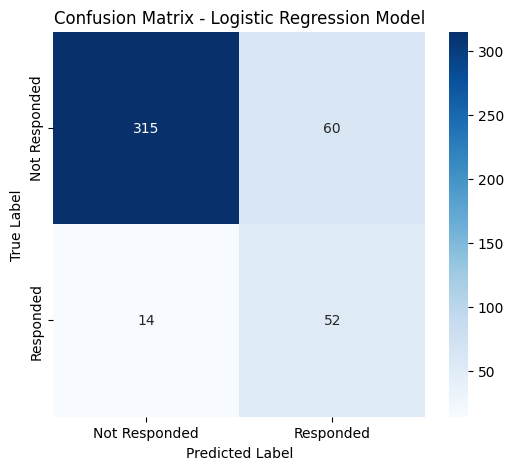

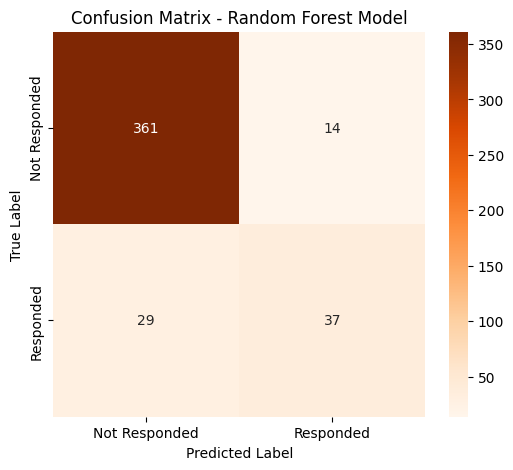

In [42]:
print("--- Accuracy ----------------------------------------------------------")
print("Logistic Regression Optimized Accuracy:", accuracy_best_logreg)
print("Random Forest Optimized Accuracy:", accuracy_best_rf)
print("--- Precision ---------------------------------------------------------")
print("Logistic Regression Precision:", precision_best_logreg)
print("Random Forest Precision:", precision_best_rf)
print("--- Recall ------------------------------------------------------------")
print("Logistic Regression Recall:", recall_best_logreg)
print("Random Forest Recall:", recall_best_rf)
print("--- F1 Score ----------------------------------------------------------")
print("Logistic Regression F1 Score:", f1_best_logreg)
print("Random Forest F1 Score:", f1_best_rf)
print("--- ROC AUC -----------------------------------------------------------")
print("Logistic Regression ROC AUC:", roc_auc_best_logreg)
print("Random Forest ROC AUC:", roc_auc_best_rf)
print("--- Logistics Regression Confusion Matrix -----------------------------")
print("\nLogistic Regression Confusion Matrix:\n", conf_matrix_best_logreg)
print("--- Random Forest Confusion Matrix ------------------------------------")
print("\nRandom Forest Confusion Matrix:\n", conf_matrix_best_rf)
print("\nLogistic Regression Optimized Report:\n", classification_report_best_logreg)
print("\nRandom Forest Optimized Report:\n", classification_report_best_rf)

# Plot Confusion Matrix for Logistic Regression
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_best_logreg, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Responded", "Responded"],
            yticklabels=["Not Responded", "Responded"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression Model")
plt.show()

# Plot Confusion Matrix for Random Forest
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_best_rf, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Not Responded", "Responded"],
            yticklabels=["Not Responded", "Responded"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Model")
plt.show()

# Step 15: Conclusion

**Accuracy & General Performance**

Overall Accuracy:

* Logistic Regression: 86.17%
* Random Forest: 87.53%
* Conclusion: Both models perform well in overall accuracy, but this is mainly because they excel at identifying non-responders (Class 0).

**Class Imbalance Issue (Bias Toward Non-Responders)**
* Both models struggle with correctly identifying responders (Class 1):
* Low Recall (Logistic Regression: 22.7%, Random Forest: 21.2%)
* This means the models fail to correctly identify most actual responders.
* Out of 66 actual responders, Logistic Regression only correctly predicts 15, and Random Forest only 14.
* Precision is better (Logistic Regression: 60%, Random Forest: 82%)
When the models predict a positive response (Class 1), it’s more likely to be correct.

***Implication***: The model is very conservative in predicting responders. It is biased towards predicting non-responders because the dataset contains far more non-responders (375) than responders (66).

**Confusion Matrix Interpretation**

1.   Logistic Regression
* Correctly predicts 365 non-responders (True Negatives) out of 375.
* Misclassifies 51 responders as non-responders (False Negatives) → Misses 77% of actual responders.
* Only correctly identifies 15 responders (True Positives).

2.   Random Forest Classifier
* Correctly predicts 372 non-responders (True Negatives), slightly better than Logistic Regression.
* Misses 52 responders (False Negatives).
* Identifies 14 responders correctly (True Positives).

***Implication***: False negatives are a big issue – these are people who would have responded, but the model failed to identify them. Companies could lose potential customers because the model does not recommend targeting them with campaigns.

**ROC AUC Score (Ability to Differentiate Classes)**
* Logistic Regression: 0.60
* Random Forest: 0.60
* Conclusion: A random classifier would score 0.50, meaning our models are only slightly better than random guessing when distinguishing between responders and non-responders.

**Final Conclusion**
* The model is good at predicting who will NOT respond but struggles to predict actual responders.
* Companies using this model may miss a lot of potential customers (false negatives).
* This suggests we need improvements to increase recall (correctly predicting more responders).

# Model Performance Summary
We evaluated two machine learning models—Logistic Regression and Random Forest—to predict customer responses to marketing campaigns. The objective is to identify customers who are likely to respond, in order to effectively target them for marketing efforts. Below is a comparison of the two models based on key performance metrics:

| Metric         | Logistic Regression | Random Forest |
|----------------|---------------------|---------------|
| **Accuracy**   | **83.2%**           | **90.2%**     |
| **Precision**  | **46.4%**           | **72.5%**     |
| **Recall**     | **78.8%**           | **56.1%**     |
| **F1 Score**   | **58.4%**           | **63.2%**     |
| **ROC AUC**    | **81.4%**           | **76.2%**     |

## Interpretation of Results
Logistic Regression demonstrates strong performance with a high recall of 78.8%, meaning it identifies a larger proportion of potential responders. While its precision (46.4%) is lower, this tradeoff is acceptable when the focus is on maximizing recall, as we aim to capture as many positive instances as possible for the marketing campaign. The F1 Score of 58.4% reflects a reasonable balance between precision and recall, and the ROC AUC score of 81.4% indicates strong discriminatory ability.

Random Forest achieves higher accuracy (90.2%) and precision (72.5%), but its recall is lower (56.1%), meaning it misses a significant portion of potential responders. The F1 Score of 63.2% suggests a better tradeoff between precision and recall compared to Logistic Regression, but it still falls short of the recall required to capture a higher number of responders.

## Recommendation
Given the goal is to maximize recall in order to capture as many potential responders as possible, Logistic Regression is the more suitable model despite its lower precision. By optimizing for recall, we can ensure that a larger number of customers are identified for targeted marketing, even at the cost of mistakenly including some non-responders.